In [46]:
%matplotlib inline

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
from scipy.spatial.distance import cdist
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

In [97]:
train_housing = pd.read_csv("train.csv")
test_housing = pd.read_csv("test.csv")

In [3]:
train_housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [73]:
print train_housing.shape

(1460, 81)


In [74]:
test_housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
print test_housing.shape

(1459, 80)


In [7]:
train_housing.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [8]:
train_housing.dtypes.head()

Id               int64
MSSubClass       int64
MSZoning        object
LotFrontage    float64
LotArea          int64
dtype: object

In [9]:
train_housing.apply(lambda col: col.isnull()).sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [10]:
train_housing.apply(lambda col: col.isnull()).mean().value_counts()

0.000000    62
0.055479     5
0.025342     3
0.005479     2
0.026027     2
0.472603     1
0.807534     1
0.995205     1
0.177397     1
0.000685     1
0.937671     1
0.963014     1
dtype: int64

In [11]:
train_data, train_price = train_housing.loc[:,'Id':'SaleCondition'], train_housing['SalePrice']

In [98]:
test_data = test_housing

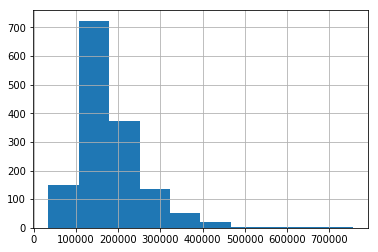

In [13]:
train_price.hist()

In [14]:
X = pd.DataFrame(train_price.values.reshape(-1, 1))

from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)
km.fit(X)
km.cluster_centers_

array([[147265.14196983],
       [294826.21921922]])

In [15]:
labels = km.predict(X)
labels

array([0, 0, 1, ..., 1, 0, 0], dtype=int32)

In [16]:
dists = km.transform(X)
dists

array([[ 61234.85803017,  86326.21921922],
       [ 34234.85803017, 113326.21921922],
       [ 76234.85803017,  71326.21921922],
       ...,
       [119234.85803017,  28326.21921922],
       [  5140.14196983, 152701.21921922],
       [   234.85803018, 147326.21921922]])

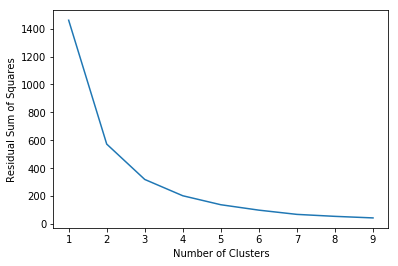

In [17]:
clusts = range(1, 10)

def kmean_rss_score(nclust):
    km = Pipeline([('scale', StandardScaler()), ('cluster', KMeans(nclust))])
    km.fit(X)
    rss = -km.score(X)
    return rss

rss = [kmean_rss_score(i) for i in clusts]
plt.plot(clusts, rss)
plt.xlabel('Number of Clusters')
plt.ylabel('Residual Sum of Squares')
plt.show()

In [18]:
# Separate predictors into numeric and categorical groups
numeric_predictors = [
    '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'WoodDeckSF',
    'LotFrontage', 'LotArea', 'ScreenPorch', 'MiscVal', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea',
    'LowQualFinSF', 'MasVnrArea', 'MasVnrArea', 'OpenPorchSF', 'PoolArea', 'TotRmsAbvGrd'
]
categorical_predictors = train_data.columns.difference(numeric_predictors)

In [19]:
train_data[categorical_predictors].head().T

,0,1,2,3,4
Alley,NaN,NaN,NaN,NaN,NaN
BedroomAbvGr,3,3,3,3,4
BldgType,1Fam,1Fam,1Fam,1Fam,1Fam
BsmtCond,TA,TA,TA,Gd,TA
BsmtExposure,No,Gd,Mn,No,Av
BsmtFinType1,GLQ,ALQ,GLQ,ALQ,GLQ
BsmtFinType2,Unf,Unf,Unf,Unf,Unf
BsmtFullBath,1,0,1,1,1
BsmtHalfBath,0,1,0,0,0
BsmtQual,Gd,Gd,Gd,TA,Gd


In [30]:
# Instantiate modules required for numeric predictors

def select_numeric_features(X):
    return X[numeric_predictors]

# Instantiate necessary modules
numeric_selector = FunctionTransformer(select_numeric_features, validate=False)
imp = Imputer(strategy='mean')
ss = StandardScaler()

# Instantiate modules required for categorical predictors

def select_categorical_features(X):
    return X[categorical_predictors]

scf = FunctionTransformer(select_categorical_features, validate=False)

def ensure_datatype(X):
    return X.apply(lambda col: col.astype(str))

ed = FunctionTransformer(ensure_datatype, validate=False)

from sklearn.feature_extraction import DictVectorizer

def make_dictionaries(X):
    return X.to_dict(orient='records')

md = FunctionTransformer(make_dictionaries, validate=False)

In [31]:
numeric_feature_pipeline = Pipeline(steps=[
    ('select', FunctionTransformer(select_numeric_features, validate=False)),
    ('impute', Imputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('select', FunctionTransformer(select_categorical_features, validate=False)),
    ('datatype', FunctionTransformer(ensure_datatype, validate=False)),
    ('dictionaries', FunctionTransformer(make_dictionaries, validate=False)),
    ('vectorize', FeatureHasher(n_features=200))
])

fu = FeatureUnion([
    ('categorical', categorical_pipeline), 
    ('numeric', numeric_feature_pipeline)
])

In [32]:
transformed_train = fu.fit_transform(train_data)
transformed_test = fu.transform(test_data)

In [33]:
transformed_train.shape

(1460, 220)

In [34]:
transformed_test.shape

(1459, 220)

In [25]:
search_params = {
    'preprocess__categorical__vectorize__n_features': [5, 15, 75, 100, 200],
    'preprocess__numeric__impute__strategy': ['mean', 'median', 'most_frequent'],
    'predict__alpha': [1, 10, 50, 100, 200, 500]
}

In [78]:
model_pipe_ridge = Pipeline(steps=[
    ('preprocess', fu),
    ('predict', Ridge(alpha=100))
])

In [91]:
grid_search = GridSearchCV(model_pipe_ridge, search_params, cv=5)
clf_ridge = grid_search.fit(train_data, train_price)
grid_search.best_params_

{'predict__alpha': 100,
 'preprocess__categorical__vectorize__n_features': 200,
 'preprocess__numeric__impute__strategy': 'most_frequent'}

In [99]:
prices = clf_ridge.predict(test_data)

In [100]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [101]:
test_data['SalePrice'] = prices
columns_submission = ['Id', 'SalePrice']
test_data.to_csv('tako_hisada_submission_baseline_20180313_ridge.csv', columns=columns_submission, index=False)

In [83]:
model_pipe_lasso = Pipeline(steps=[
    ('preprocess', fu),
    ('predict', Lasso(alpha=100))
])

In [84]:
grid_search = GridSearchCV(model_pipe_lasso, search_params, cv=10)
clf_lasso = grid_search.fit(train_data, train_price)
grid_search.best_params_

{'predict__alpha': 500,
 'preprocess__categorical__vectorize__n_features': 200,
 'preprocess__numeric__impute__strategy': 'most_frequent'}

In [85]:
prices = clf_lasso.predict(test_data)

In [88]:
test_data['SalePrice'] = prices
columns_submission = ['Id', 'SalePrice']

In [89]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,103620.425909
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,167407.560596
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,186255.883872
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,218138.851784
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,166963.603714


In [90]:
test_data.to_csv('tako_hisada_submission_baseline_20180313_lasso.csv', columns=columns_submission, index=False)